In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load data and divide into train and test sets

In [16]:
TrainingImagePath='./processed';
# Loading dataset without augmentation
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    TrainingImagePath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(200, 200),
    batch_size=32,
)

testing_set = tf.keras.preprocessing.image_dataset_from_directory(
    TrainingImagePath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(200, 200),
    batch_size=32,
)



Found 27 files belonging to 3 classes.
Using 22 files for training.
Found 27 files belonging to 3 classes.
Using 5 files for validation.


In [17]:
class_names = training_set.class_names
print(class_names)

['khalil', 'malek', 'others']


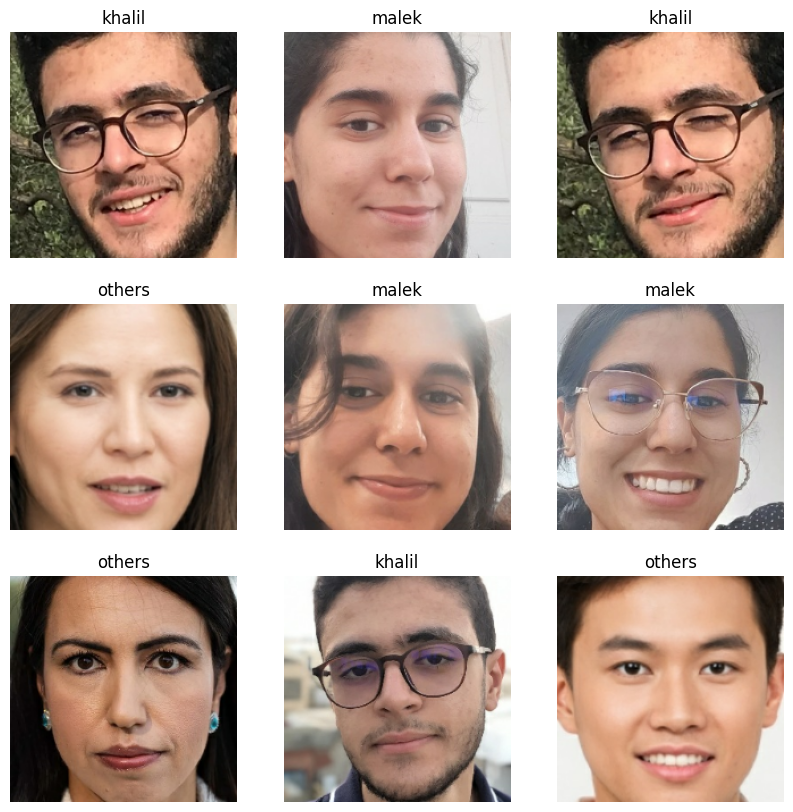

In [18]:
# Visualizing the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

normalizing the data

0.022226384 0.99874514


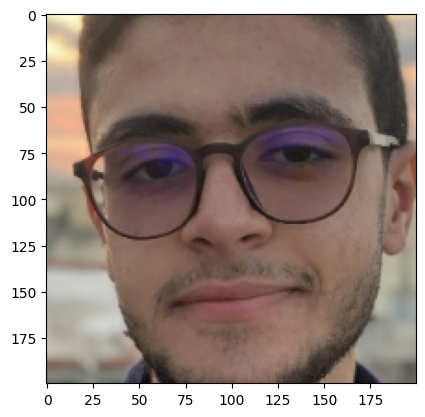

In [19]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
plt.imshow(first_image)


A basic Keras model

In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(200, 200, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)       

Train the model (Train the model for 10 epochs with the Keras Model.fit method)



In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=3)
# This callback will stop the training when there is no improvement in the loss for 2 consecutive epochs.

history = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=10, 
  #callbacks=[callback],
)
epochs=len(history.history['loss'])

Epoch 1/10
1/1 [==============================] - 1s 929ms/step - loss: 1.1039 - accuracy: 0.2727 - val_loss: 1.8526 - val_accuracy: 0.2000
Epoch 2/10
1/1 [==============================] - 0s 447ms/step - loss: 1.4593 - accuracy: 0.3636 - val_loss: 1.5602 - val_accuracy: 0.4000
Epoch 3/10
1/1 [==============================] - 0s 438ms/step - loss: 2.1617 - accuracy: 0.3182 - val_loss: 1.2077 - val_accuracy: 0.4000
Epoch 4/10
1/1 [==============================] - 0s 453ms/step - loss: 1.5579 - accuracy: 0.3182 - val_loss: 1.1037 - val_accuracy: 0.4000
Epoch 5/10
1/1 [==============================] - 0s 448ms/step - loss: 1.2839 - accuracy: 0.3182 - val_loss: 0.9934 - val_accuracy: 0.4000
Epoch 6/10
1/1 [==============================] - 0s 448ms/step - loss: 1.0204 - accuracy: 0.3636 - val_loss: 0.9884 - val_accuracy: 0.4000
Epoch 7/10
1/1 [==============================] - 0s 440ms/step - loss: 0.9243 - accuracy: 0.5909 - val_loss: 0.9986 - val_accuracy: 0.8000
Epoch 8/10
1/1 [====

In [23]:
epochs

10

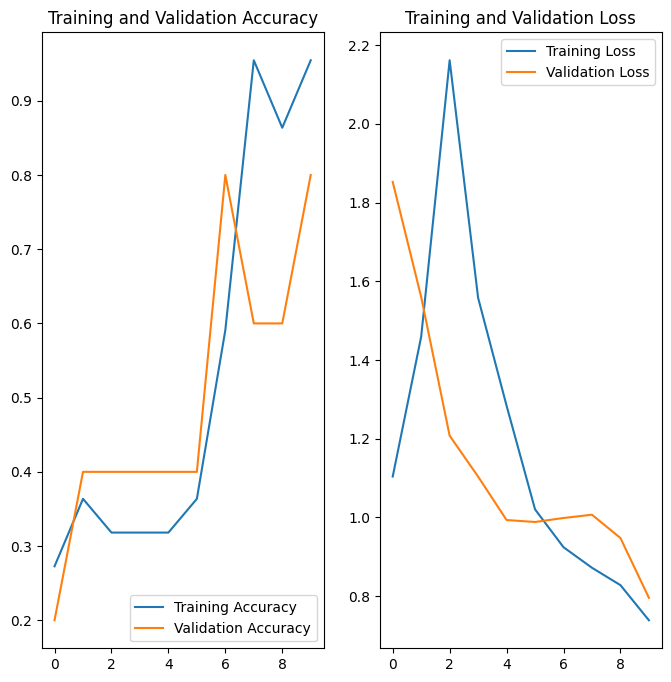

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data


In [29]:
im_path='others11.jpg'

img = tf.keras.utils.load_img(
    im_path, target_size=(200, 200)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to others with a 42.56 percent confidence.
